In [1]:
### fetch_mldata('MNIST original')でRemoteDisconnectedエラーが出た場合

# https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat 
# ↑から mnist-original.mat をダウンロード

from sklearn.datasets.base import get_data_home 
print (get_data_home()) # これで表示されるパスに mnist-original.mat を置く

C:\Users\nk\scikit_learn_data


In [2]:
# proxyの設定
import urllib.request

#proxy = urllib.request.ProxyHandler({'https': 'https://proxy.uec.ac.jp:8080'})
#opener = urllib.request.build_opener(proxy)
#urllib.request.install_opener(opener)

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1,)


この画像データのラベルは5です


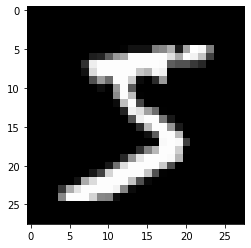

In [3]:
# MNISTデータの前処理
# 28x28ピクセルごとの0-255の数値を0-1に変換
X = mnist.data / 255  
# 正解ラベルを取得
y = mnist.target

# MNISTのデータの1つ目をmatplotlib.pyplotで描画する
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X[0].reshape(28, 28), cmap='gray')
print("この画像データのラベルは{}です".format(y[0]))


In [5]:
# 画像データのインポート


In [6]:
# DataLoderの作成

import torch
from torch.utils.data import TensorDataset, DataLoader
from spp_layer import spatial_pyramid_pool

# データを訓練とテストのために、6:1に分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/7, random_state=0)

# 5-2. データのフォーマットを変換：PyTorchでの形式 = [画像数，チャネル数，高さ，幅]
X_train = X_train.reshape(60000, 1, 28, 28)
X_test = X_test.reshape(10000, 1, 28 ,28)

y_train = y_train.astype("float64")
y_test = y_test.astype("float64")

# データをPyTorchのTensorに変換
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# データとラベルをセットにしたDatasetを作成
ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

# データセットのミニバッチサイズを指定した、Dataloaderを作成
loader_train = DataLoader(ds_train, batch_size=64, shuffle=True)
loader_test = DataLoader(ds_test,batch_size=64,  shuffle=False)


In [20]:
# 畳み込みニューラルネットワークの設定
import torch.nn as nn
import torch.nn.functional as F

num_layer = 2                   # 畳み込み層の数
num_filters = [16, 32]          # 各畳み込み層のフィルタ数
mid_units = 100                 # 全結合層のユニット数

in_height = 28
in_width = 28
kernel = 3
#dropout_prob = 0.0

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    
    self.conv1 = nn.Conv2d(1, num_filters[0], 3)
    self.conv2 = nn.Conv2d(num_filters[0], num_filters[1], 3)
    
    self.output_num = [4,2,1]
    
    self.fc1 = nn.Linear(in_features= num_filters[1]*11*11, out_features=mid_units) 
    self.fc2 = nn.Linear(in_features=mid_units, out_features=10)
        

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    #x = F.relu(F.max_pool2d(self.conv2(x), 2))
    
    # 最後のpooling層のみSPP層に変更
    x = self.conv2(x)
    # print(x.size())
    spp = spatial_pyramid_pool(self,x,1,[int(x.size(2)),int(x.size(3))],self.output_num)
    #x = F.relu(spp)
    print(x.size())
    
    x = x.view(x.size(0),-1)
    print(x.size())
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


In [8]:
optimizer = torch.optim.Adam(model.parameters())

In [9]:
# 5. 学習と推論の設定
# 学習1回でやることを定義します
# Chainerのtraining.Trainer()に対応するものはない

from torch.autograd import Variable

def train(epoch):
    model.train()
    # ネットワークを学習モードに切り替える

    # データローダーから1ミニバッチずつ取り出して計算する
    for data, target in loader_train:
        data, target = Variable(data), Variable(target)  # 微分可能に変換
        optimizer.zero_grad()  # 一度計算された勾配結果を0にリセット
 
        output = model(data)  # 入力dataをinputし、出力を求める
        loss = loss_fn(output, target)  # 出力と訓練データの正解との誤差を求める
        loss.backward()  # 誤差のバックプロパゲーションを求める
        optimizer.step()  # バックプロパゲーションの値で重みを更新する

    print("epoch{}：終了\n".format(epoch))

In [10]:
def test():
    # ネットワークを推論モードに切り替える
    model.eval()
    correct = 0
    # データローダーから1ミニバッチずつ取り出して計算する
    for data, target in loader_test:
        data, target = Variable(data), Variable(target)
        # 微分可能に変換
        output = model(data)
        # 入力dataをinputし、出力を求める
        
        # 推論する
        pred = output.data.max(1, keepdim=True)[1]
        # 出力ラベルを求める
        correct += pred.eq(target.data.view_as(pred)).sum()
        # 正解と一緒だったらカウントアップ
        # 正解率を出力
        data_num = len(loader_test.dataset)
        
    # データの総数
    print('\nテストデータの正解率: {}/{} ({:.0f}%)\n'.format(correct, data_num, 100. * correct / data_num))

In [21]:
# 学習なしにテストデータで推論
test()


[11, 11]
[11, 11]
[11, 11]
torch.Size([64, 32, 11, 11])
torch.Size([64, 3872])


RuntimeError: size mismatch, m1: [64 x 3872], m2: [800 x 100] at C:\w\1\s\tmp_conda_3.7_160731\conda\conda-bld\pytorch_1570810122324\work\aten\src\TH/generic/THTensorMath.cpp:197

In [10]:
# max-pooling
# 60000のデータに3エポック学習を実行する
for epoch in range(3):
    train(epoch)
 
test()

NameError: name 'loader_train' is not defined

In [237]:
study.best_value
1-0.0106

0.9894

In [ ]:
# spp
# 60000のデータに3エポック学習を実行する
for epoch in range(3):
    train(epoch)
 
test()